# Parte 1: Match Template de un patrón
En esta parte se presentan los algoritmos que permitieron detectar de forma general el patrón suministrado sobre todo el set de imágenes. Vale aclarar que las funciones están referenciadas según el algoritmo de Canny, ya que es el que ha funcionado para este caso particular. Pero podría en todo caso, extenderse a otrós métodos de detección de bordes. 

In [1]:
# Librerías principales
import numpy as np
import cv2 as cv
import matplotlib
from matplotlib import pyplot as plt

# Tratamiento de archivos
import glob

# Tipo de visualización
%matplotlib inline

# Versiones de librerías
print("".join(f"{x[0]}: {x[1]}\n" for x in [
    ("Numpy",np.__version__),
    ("openCV",cv.__version__),
    ("Matplotlib",matplotlib.__version__),
]))

Numpy: 1.22.3
openCV: 4.5.5
Matplotlib: 3.5.1



In [2]:
# Definición de la ruta para levantar las imagenes
TEMPLATE_DIR = '.\Template'
IMG_DIR = '.\images'
TEMPLATE_NAME = 'pattern.png'

## Funciones auxiliares
Función para cargar y guardar en una lista todas las imágenes a realizarle la detección


In [3]:
def load_images(img_fnames):
    imgs = []
    for fname in img_fnames:
        img = cv.imread(fname)
        imgs.append(img)
    
    print(f'Se cargaron {len(imgs)} imágenes'.format(len(imgs)))
    return imgs

## Funciones para Match Template generales
Se presentan las tres funciones que permiten tratar y visualizar la lista completa de imágenes presentadas en el trabajo práctico:
- _match template Canny_: realiza el proceso de detección del patrón en la imagen.
- _all match Canny_: realiza el proceso de detección del patrón sobre todo el set de imágenes.
- _result graph_: presenta las imágenes con la detección en un array para su visualización.  

In [19]:
def match_template_canny(image, template, param_canny, range_scale, method):
	'''
	Función que devuelve la detección de un patrón, empleando como detección de bordes el algoritmo de Canny
	image: imagen a tratar.
	template: imagen patrón.
	param_canny: parámetros para la función de canny de OpenCV.
	range_scale: array con todos los valores de escala a barrer para modificar la imagen.
	method: método empleado para la detección.
	'''

	# Dimensiones del template: ancho (coord. X, tW), altura (coord. y, tH)
	tH, tW = template.shape[:2]

	# Parámetros de Canny 
	p1 = param_canny[0]
	p2 = param_canny[1]

	# Método para aplicar Match Template
	meth_match = eval(method)

	# Conversión del template a escala de grises y Canny
	t_gray = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
	t_canny = cv.Canny(t_gray, p1, p2)
	
	# Conversión de la imagen a escala de grises
	img_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

	found = None
	
	# Se inicia el ciclo probando valores de escala
	for scale in range_scale:
			# Cambio de escala de la imagen
			dim = (int(img_gray.shape[1] * scale), int(img_gray.shape[0] * scale))
			resized = cv.resize(img_gray, dim, interpolation = cv.INTER_AREA)
			rX = img_gray.shape[1] / float(resized.shape[1])
			rY = img_gray.shape[0] / float(resized.shape[0])
			# Si la imagen reescalada es menor al template, se detiene el ciclado
			if resized.shape[0] < tH or resized.shape[1] < tW:
				break
			# Detección de bordes con Canny, se aplica la función MatchTempleta y
			# se guardan los valores máximos
			edged = cv.Canny(resized, 50, 250)
			result = cv.matchTemplate(edged, t_canny, cv.TM_CCOEFF_NORMED)
			(_, maxVal, _, maxLoc) = cv.minMaxLoc(result)
		
			# Si se encuentra un nuevo valor de métrica máximo
			# se guarda 
			if found is None or maxVal > found[0]:
				found = (maxVal, maxLoc, rX, rY)
			# Armado del unbox para indicar la detección en la imagen original
			(_, maxLoc, rX, rY) = found
			(startX, startY) = (int(maxLoc[0] * rX), int(maxLoc[1] * rY))
			(endX, endY) = (int((maxLoc[0] + tW) * rX), int((maxLoc[1] + tH) * rY))

	# Conversión de imagen original a RGB
	img_final = cv.cvtColor(image, cv.COLOR_BGR2RGB)
	# Armado de unbox con el valor de métrica de método de normalización
	label = f"{found[0]:.2f}"
	(label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 1, 2) 
	text_end = (startX + label_width, startY-15 - label_height)
	# Inserción de unbox con texto
	cv.putText(img_final, label, (startX, startY-10), cv.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
	cv.rectangle(img_final, (startX, startY), text_end, (0,255,0),3)
	# Inserción de unbox de detección
	cv.rectangle(img_final, (startX, startY), (endX, endY), (0, 255, 0), 3)
	
	return img_final

In [20]:
def all_match_canny(input_images, template, param_canny, range_scale, method):
    '''
	Función para detección de patrones sobre un dataset completo, empleando como detección de bordes el algoritmo de Canny.
	input_images: lista con las imágenes a tratar.
	template: imagen patrón.
	param_canny: parámetros para la función de canny de OpenCV.
	range_scale: array con todos los valores de escala a barrer para modificar la imagen.
	method: método empleado para la detección.

    La función retorna una lista con las imágenes y las detecciones marcadas.
	'''
    
    images_match = []
    for image in input_images:
        match = match_template_canny(image, template, param_canny, range_scale, method)
        images_match.append(match)

    return(images_match)

In [21]:
def result_graph(input_images, rows):
    '''
    Función para presentar las imágenes en una matriz
    input_images: lista de imágenes a mostrar
    rows: filas.
    '''
    columns = int(len(input_images)/rows)+1
    k = 0
    
    fig, axs = plt.subplots(rows, columns, figsize=(18, 12))
    for i in range(rows):
        for j in range(columns):
            axs[i, j].imshow(input_images[k])
            k += 1
            if k == len(input_images):
                break


## Prceso de Match Template

In [22]:
# Carga de imágenes
img_fnames = glob.glob(IMG_DIR + '\*.*')
input_images = load_images(img_fnames)

# Carga de template
template = cv.imread(os.path.join(TEMPLATE_DIR, TEMPLATE_NAME))

Se cargaron 7 imágenes


In [23]:
# Valores de parámetros
param_canny = [50, 250]
range_scale = np.linspace(0.05, 4.0, 120)[::-1]
method = 'cv.TM_CCOEFF_NORMED'
imp = input_images[5]

In [ ]:
# Set de imágenes con detección
set_images_match = all_match_canny(input_images, template, param_canny, range_scale, method)

## Resultados y conclusiones
La función _match template canny_ logró su cometido primordial. Ha logrado detectar los casos más complicados. La generalización en algunas situaciones baja la performance, ya que el área toma sectores ajenos al patrón. 

Se han presentado varias particularidades. Primero influyó la selección del rango y paso de los valores de escala a barrer. Pero también los valores de los parámetros de la función de Canny de OpenCV. Una particularidad se presentó a la hora de convertir las imágenes originales de BRG a RGB. Este método no funcionaba. Ante todo, primero se ha convertido de BRG a GRAY, para si luego, con el objetivo de mostrar resultados finales, se hizo la conversión de BGR a RGB.

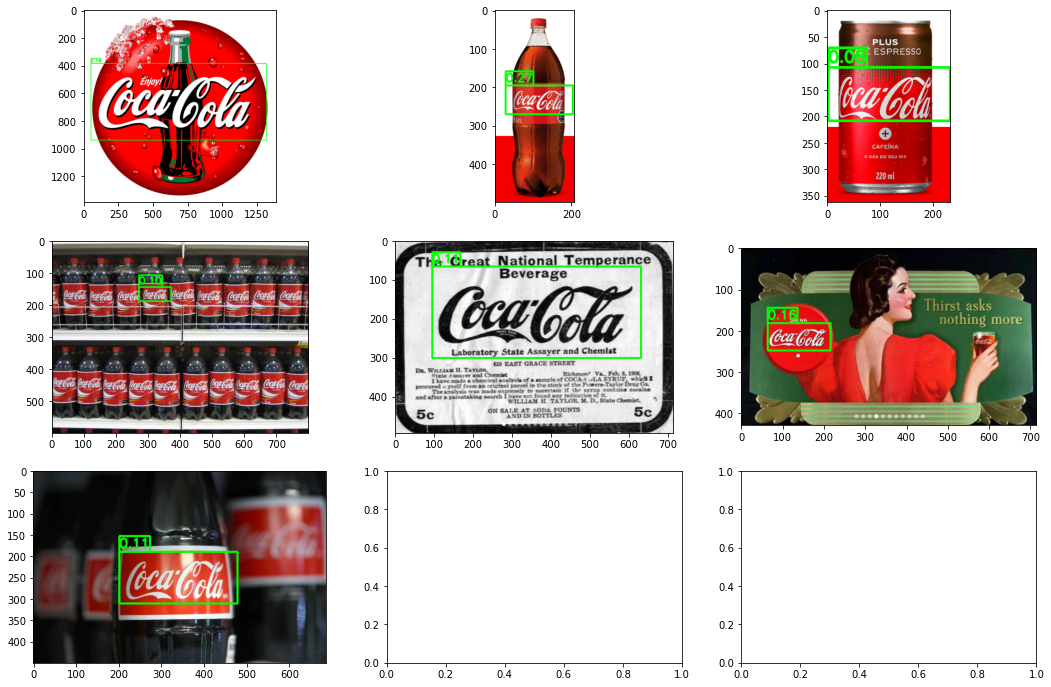

In [25]:
result_graph(set_images_match, 3)